# **Introduction**
The goal of this project is to create a predictive model that estimates the price of apartments in Poland's largest cities based on key variables. <br>
The data used in this project comes from otodom.pl, the largest real estate listing portal in the country. <br>
The data was independently collected using web scraping techniques on June 7, 2024, for the major Polish cities: Warsaw, Krakow, Gdansk, Lodz, Wroclaw, and Poznan.

# **Data Preparation**

To start with our data analysis, we need to import the necessary packages. <br>
Here are the common packages we need:

In [2]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
import category_encoders as ce
import psycopg2
import pickle
import gzip
import subprocess
from psycopg2 import sql
from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey, UniqueConstraint
from sqlalchemy.orm import declarative_base, relationship, sessionmaker
from sqlalchemy.exc import SQLAlchemyError
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_error
from matplotlib import pyplot

Next step is to load the data obtained from web scraping:

In [3]:
df = pd.read_csv('otodom_listings.csv', sep=';')

...and displaying the first 40 records to get a glance at the acquired data:

In [4]:
df.head(n=40)

,adres,area,number_of_rooms,floor,rent,building_ownership,construction_status,outdoor,car,heating,price,market,lift,build_year,advertiser_type,extra_info,building_type,url
0,"ul. Ciepla, Mirow, Wola, Warszawa, mazowieckie","32,89 m2",NaN,> 10/16,NaN,pelna wlasnosc,do wykonczenia,NaN,garaz/miejsce parkingowe,NaN,1 161 000 zl,NaN,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/1-pokojowe-mie...
1,"Saska Kepa, Praga-Poludnie, Warszawa, mazowieckie","78,63 m2",2,parter/5,821 zl,pelna wlasnosc,do zamieszkania,"balkon, ogrodek, taras",garaz/miejsce parkingowe,miejskie,1 499 000 zl,wtorny,tak,2010,biuro nieruchomosci,"klimatyzacja, piwnica, pom. uzytkowe",apartamentowiec,https://www.otodom.pl/pl/oferta/sprzedam-2-pok...
2,"ul. Kozla, Nowe Miasto, Srodmiescie, Warszawa,...",50 m2,2,3/3,480 zl,pelna wlasnosc,NaN,NaN,NaN,miejskie,898 000 zl,wtorny,nie,1956,biuro nieruchomosci,dwupoziomowe,kamienica,https://www.otodom.pl/pl/oferta/kamienica-na-n...
3,"Okecie, Wlochy, Warszawa, mazowieckie","61,2 m2",3,2/4,1 000 zl,pelna wlasnosc,do zamieszkania,balkon,garaz/miejsce parkingowe,miejskie,1 178 100 zl,wtorny,tak,2017,biuro nieruchomosci,"piwnica, pom. uzytkowe",blok,https://www.otodom.pl/pl/oferta/3-pokoje-blisk...
4,"Zielona-Grzybowa, Wesola, Warszawa, mazowieckie","80,44 m2",4,parter/1,80 zl,pelna wlasnosc,NaN,"balkon, ogrodek, taras",garaz/miejsce parkingowe,inne,1 077 000 zl,pierwotny,nie,2025,deweloper,pom. uzytkowe,apartamentowiec,https://www.otodom.pl/pl/oferta/loft-garden-we...
5,"ul. Mangalia, Stegny, Mokotow, Warszawa, mazow...",108 m2,5,1/7,1 100 zl,pelna wlasnosc,do wykonczenia,"balkon, taras",garaz/miejsce parkingowe,miejskie,1 830 000 zl,pierwotny,tak,2020,biuro nieruchomosci,oddzielna kuchnia,apartamentowiec,https://www.otodom.pl/pl/oferta/przestronne-mi...
6,"Wrzeciono, Bielany, Warszawa, mazowieckie","56,6 m2",3,parter/10,900 zl,pelna wlasnosc,do zamieszkania,NaN,NaN,miejskie,735 000 zl,wtorny,nie,brak informacji,prywatny,"piwnica, oddzielna kuchnia",blok,https://www.otodom.pl/pl/oferta/mieszkanie-3-p...
7,"Stary Mokotow, Mokotow, Warszawa, mazowieckie","66,35 m2",3,2/2,780 zl,pelna wlasnosc,do zamieszkania,NaN,NaN,NaN,1 250 000 zl,wtorny,nie,1926,biuro nieruchomosci,"piwnica, oddzielna kuchnia",kamienica,https://www.otodom.pl/pl/oferta/prestizowa-lok...
8,"ul. Leona Berensona, Grodzisk, Bialoleka, Wars...",35 m2,2,NaN,NaN,pelna wlasnosc,NaN,balkon,garaz/miejsce parkingowe,NaN,465 000 zl,pierwotny,tak,2024,biuro nieruchomosci,brak informacji,blok,https://www.otodom.pl/pl/oferta/kupuj-bezposre...
9,"Ursynow Polnocny, Ursynow, Warszawa, mazowieckie","63,65 m2",3,3/3,720 zl,pelna wlasnosc,do zamieszkania,balkon,NaN,miejskie,985 000 zl,wtorny,nie,1990,biuro nieruchomosci,"piwnica, oddzielna kuchnia",blok,https://www.otodom.pl/pl/oferta/rewelacyjna-lo...


Here is a brief explanation of the variables present in the data frame: <br>

**adres** : Location of the apartment. <br>
**area** : Total area of the apartment in square meters. <br>
**number_of_rooms** : Number of rooms in the apartment. <br>
**floor** : The floor on which the apartment is located along with the total height of the building. <br>
**rent** : Monthly rent expressed in Polish zloty (zl). <br>
**building_ownership** : Ownership type of the apartment. <br>

<blockqoute> The following types of ownership are distinguished:
*  *pelna wlasnosc*: full ownership, <br>
*  *spoldzielcze wl. prawo do lokalu*: cooperative ownership right to the premises, <br>
*  *udzial*: share, <br>
*  *uzytkowanie wieczyste/dzierzawa*: perpetual usufruct/lease. </blockquote>

**construction_status** : Apartment finishing status. <br>

<blockqoute> There are three types of apartment finishing status:

*  *do zamieszkania*: an apartment ready for occupancy,
*  *do remontu*: an apartment requiring renovation,
*  *do wykonczenia*: an apartment in a raw state. </blockquote>

**outdoor** : External infrastructure of the apartment. <br>

<blockqoute> Each apartment can have:

*  *balkon*: balcony,
*  *taras*: terrace,
*  *ogrod*: garden,

in any configuration. </blockquote>

**car** : Presence of a garage/parking space associated with the apartment. <br>
**heating** : Type of apartment heating. <br>

<blockqoute> The following types of apartment heating are distinguished:

*  *miejskie*: district heating,
*  *gazowe*: gas heating,
*  *elektryczne*: electric heating,
*  *kotlowania*: boiler heating,
*  *piece kaflowe*: tiled stove heating,
*  *inne*: other types of heating. </blockquote>

**price** : Total price of the apartment expressed in Polish zloty (zl). <br>
**market** : One of the two types of markets from which the listing originates. <br>

<blockqoute> These are:
*  *rynek wtorny*: secondary market,
*  *rynek pierwotny*: primary market. </blockquote>

**lift** : The presence of an elevator in the building. <br>

<blockqoute> The variable takes the following values:
*  *tak*: if the building has an elevator,
*  *nie*: if the building does not have an elevator. </blockquote>

**build_year** : The year the building was constructed. <br>
**advertiser_type** : Type of advertiser. <br>

<blockqoute> The apartment can be listed by:
*  *prywatny*: a private individual,
*  *deweloper*: a developer,
*  *biuro nieruchomości*: a real estate agency. </blockquote>

**extra_info** : Additional information about apartment. <br>

<blockqoute> Each apartment can have:
*  *piwnica*: a basement,
*  *pom. uzytkowe*: a utility room,
*  *oddzielna kuchnia*: a separate kitchen,
*  *dwupoziomowe*: be a duplex,
*  *klimatyzacja*: air conditioning,
  
in any configuration. </blockquote>

**building_type** : The type of building in which the listed apartment is located. <br>

<blockqoute> The following types of buildings are distinguished:
*  *blok*: block,
*  *apartamentowiec*: apartment building,
*  *kamienica*: tenement house,
*  *plomba*: infill,
*  *dom wolnostojacy*: detached house,
*  *szeregowiec*: terraced house. </blockquote>

**url** : URL address of the listing.

In [5]:
# Getting data frame dimensions
df.shape

(44449, 18)

Our data frame contains 44449 records in 18 different columns. <br>

In [6]:
# Getting sum of duplicates
df.duplicated().sum()

np.int64(22)

There are 22 duplicates in the DataFrame. We are removing them.

In [7]:
# Deleting duplicates
df.drop_duplicates(inplace=True)

Some variables have the value 'brak informacji', which means 'no information', so we replace them with NaN:

In [8]:
df = df.replace(['brak informacji', ''], np.nan)

We are checking how many missing values are present in our DataFrame.

In [9]:
# Display the amount of missing data
missing_values_count = df.isna().sum()
missing_values_count

adres                     10
area                      64
number_of_rooms         3964
floor                    902
rent                   23875
building_ownership      8873
construction_status     9264
outdoor                11849
car                    18462
heating                12484
price                     64
market                  5318
lift                    5318
build_year             11483
advertiser_type         5318
extra_info             22353
building_type          11596
url                        0
dtype: int64

Fraction of NaN values in each column:

Text(0.5, 1.0, 'Features with fraction of Nan values')

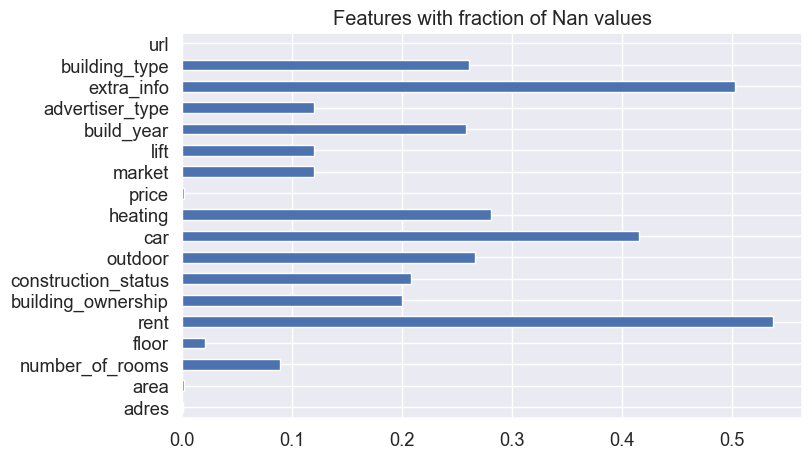

In [10]:
col_nan = df.isna().sum() / df.shape[0]
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan.plot(kind = "barh")
plt.title("Features with fraction of Nan values")

We can observe a significant amount of missing data. <br>
Some of these may simply indicate the absence of a particular attribute for a specific listing, while others may be the result of incomplete data. <br>
Our task will be to use various data preparation techniques to handle these gaps.

**URL**

Due to the fact that the *url* variable was only used to verify the correct web scraping process, we are removing it:

In [11]:
df = df.drop(columns=['url'])

**Rent**

We observe over 30% missing data for three variables: *extra_info*, *car*, and *rent*. <br>
However, for the first two, a NaN value does not necessarily mean a missing value <br>
but rather the absence of the attribute in the advertised apartment. <br> 
The absence of a rent value indicates a lack of data, as every apartment has a rent associated with it. <br>
Due to such a significant lack of information for this column, we are removing it:

In [12]:
df = df.drop(columns=['rent'])

**Price** and **Area**

Let's create our dependent variable, which is the *price_per_sq_meter*. <br>
Remove the unit suffix and convert *area* to float type:

In [13]:
# Remove the string " m2"
df['area'] = df['area'].str.replace(' m2', '')
# Replace "," with "."
df['area'] = df['area'].str.replace(',', '.')
# Convert to float type
df['area'] = df['area'].astype(float)
# Round to two decimal places
df['area'] = df['area'].round(2)

Check if the *area* variable has any outliers:

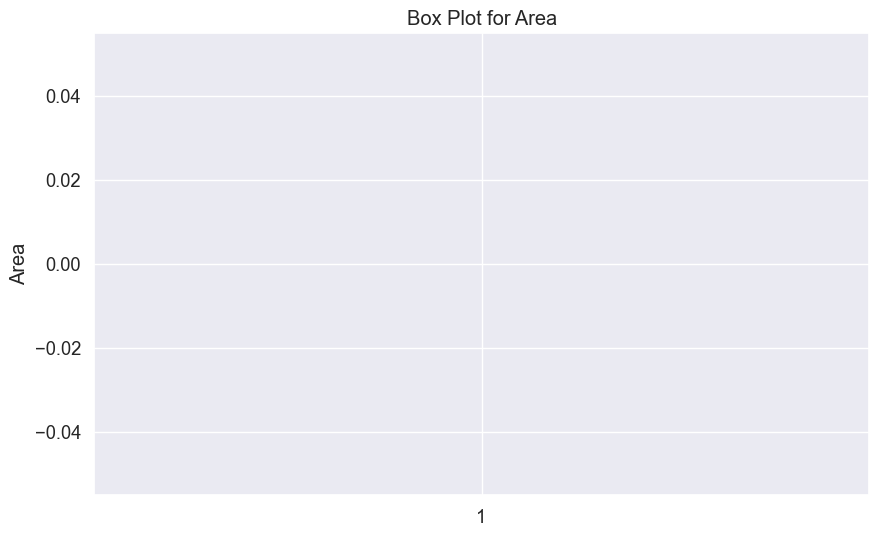

In [14]:
# Display outliers
plt.figure(figsize=(10, 6))
plt.boxplot(df['area'])
plt.title('Box Plot for Area')
plt.ylabel('Area')
plt.show()

The area variable contains some outliers. <br>
We are cleaning the data by removing listings with an area exceeding 200m²:

In [15]:
df = df[(df['area'] < 200) & (df['area'] > 10)]

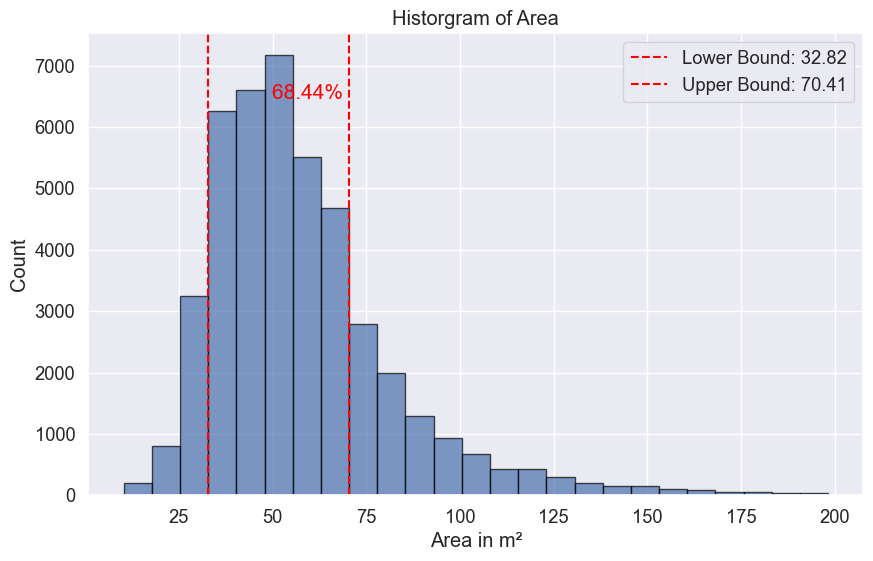

In [16]:
plt.figure(figsize=(10, 6))

# Tworzenie histogramu
n, bins, patches = plt.hist(df['area'], bins=25, edgecolor='black', alpha=0.7)

# Znalezienie 5 sąsiadujących przedziałów o największej sumarycznej częstości
max_sum = 0
max_start_idx = 0

for i in range(len(n) - 4):  # Przechodzimy tylko do (długość n - 4), żeby nie wyjść poza indeksy
    current_sum = np.sum(n[i:i+5])
    if current_sum > max_sum:
        max_sum = current_sum
        max_start_idx = i

# Graniczne wartości dla tej grupy przedziałów
lower_bound = bins[max_start_idx]
upper_bound = bins[max_start_idx + 5]

# Wielkość procentowa tej grupy względem całej zmiennej 'area'
percentage = (max_sum / np.sum(n)) * 100

# Rysowanie granicznych wartości na wykresie
plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')

# Dodanie tekstu z procentem na wykresie
plt.text(upper_bound, max(n) * 0.9, f'{percentage:.2f}% ', color='red', fontsize=15, ha='right')

# Dodanie tytułów i etykiet
plt.title('Historgram of Area')
plt.xlabel('Area in m²')
plt.ylabel('Count')

# Wyświetlenie legendy
plt.legend()

# Wyświetlenie wykresu
plt.show()

Remove records that have missing values for *price* variable or the value "Zapytaj o cenę" in various forms. <br>
To standardize its format we remove the " zl" string and spaces and make it integer.

In [17]:
# Remove records with the value "Zapytaj o cenę"
df['price'] = df['price'].replace(['Zapytaj o cenę', 'Zapytaj o cene', 'Zapytajocene'], pd.NA)

# Format change by removing the "zl" string, spaces, and replacing "," with "."
df['price'] = df['price'].str.replace(r'\s?(zł|zl|Zł|ZŁ)', '', regex=True).str.replace(' ', '').str.replace(',', '.')

# Convert to numeric values
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Remove records with NaN values
df = df.dropna(subset=['price'])

# Convert to integer type
df['price'] = df['price'].astype(int)

We replace the variable *price* with *price_per_sq_meter* by dividing the variable *price* by *area*:

In [18]:
df['price_per_sq_meter'] = df['price']/df['area']
df = df.drop(columns=['price'])

Check if the *price_per_sq_meter* variable has any outliers:

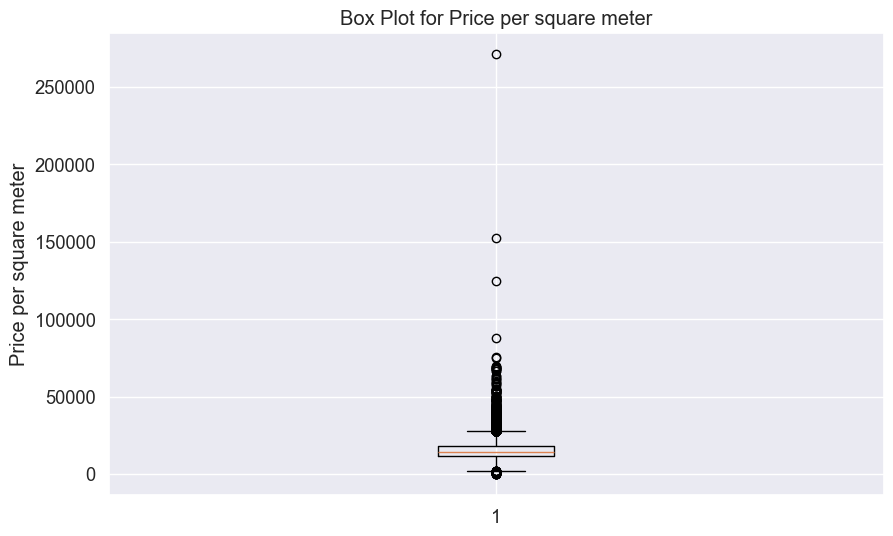

In [19]:
# Display outliers
plt.figure(figsize=(10, 6))
plt.boxplot(df['price_per_sq_meter'])
plt.title('Box Plot for Price per square meter')
plt.ylabel('Price per square meter')
plt.show()

We are cleaning the data by removing listings with a *price_per_sq_meter* exceeding 35 000 zł/m² or less than 6 000 zł/m²:

In [20]:
df = df[(df['price_per_sq_meter'] > 6000) & (df['price_per_sq_meter'] <= 35000)]

Let's look at the distribution of our target variable:

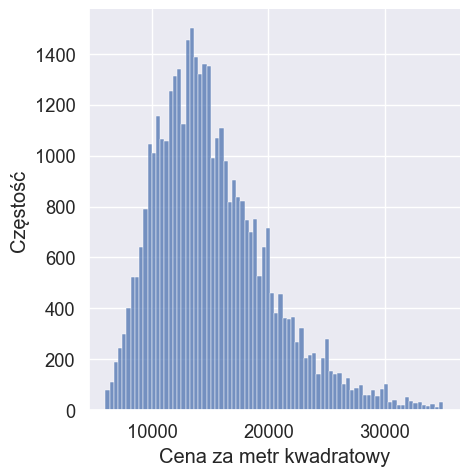

In [21]:
sns.displot(df['price_per_sq_meter'])

plt.xlabel('Cena za metr kwadratowy')
plt.ylabel('Częstość')

plt.show()

We can see that it is right-skewed distribution with the pick around 12,5k and quite long tail with maximum at 35k (because we trim it to that value). <br>
We do Logarithm transformation on *price_per_sq_meter* in order to be  more normal:

In [22]:
df['price_per_sq_meter'] = np.log1p(df['price_per_sq_meter'])

Let's check if the distribution of the variable has changed:

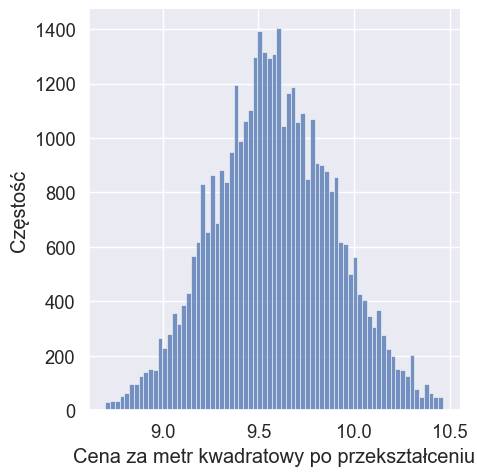

In [23]:
sns.displot(df['price_per_sq_meter'])

plt.xlabel('Cena za metr kwadratowy po przekształceniu')
plt.ylabel('Częstość')
plt.show()

We can repeat the same procedure for the *area* variable, as it is the second continuous variable in our data:

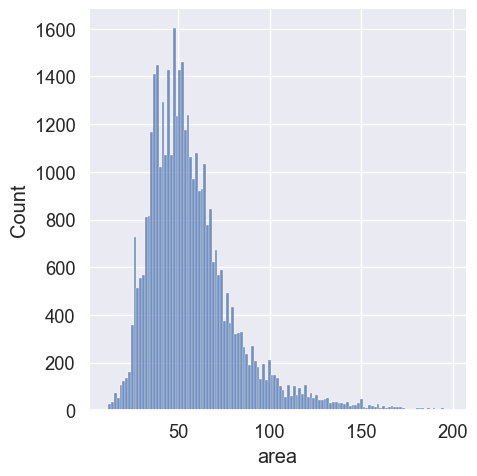

In [24]:
sns.displot(df['area'])

Due to its right-skewness, we also perform a logarithmic transformation on this feature:

In [25]:
df['area'] = np.log1p(df['area'])

**Number Of Rooms**

In [26]:
df['number_of_rooms'].isna().sum()

np.int64(3405)

We have 3405 NaN values for the *number_of_rooms* variable. These indicate missing data because every apartment must have at least one room. <br>
To fill these values, we will use the median of *number_of_rooms* based on the *area* variable.

Let's take a closer look at the values of *number_of_rooms*:

In [27]:
df['number_of_rooms'].value_counts()

number_of_rooms
2            15548
3            13421
4             5323
pierwotny     1387
5             1079
Name: count, dtype: int64

Replacing the value "pierwotny" with 1 as it appears to be a typo:

In [28]:
df.loc[df['number_of_rooms'] == 'pierwotny', 'number_of_rooms'] = 1

Conversion to float type:

In [29]:
df['number_of_rooms'] = pd.to_numeric(df['number_of_rooms'], errors='coerce')

Calculate the median *area* for each *number_of_rooms*:

In [30]:
df['original_area'] = np.expm1(df['area'])
median_area_per_room = df.groupby('number_of_rooms')['original_area'].median().reset_index()
median_area_per_room.columns = ['number_of_rooms', 'median_area']

Function to assign the *number_of_rooms* based on median *area*:

In [31]:
def assign_rooms(row, median_area_per_room):
    if pd.isna(row['number_of_rooms']):
        closest_rooms = median_area_per_room.iloc[(median_area_per_room['median_area'] - row['original_area']).abs().argsort()[:1]]
        return closest_rooms['number_of_rooms'].values[0]
    return row['number_of_rooms']

Applying the function to fill missing values:

In [32]:
# Applying the function to fill missing values
df['number_of_rooms'] = df.apply(lambda row: assign_rooms(row, median_area_per_room), axis=1).astype(int)

# Dropping original_area column
df.drop(columns=['original_area'], inplace=True)

Confirm the filling operation:

In [33]:
print(df['number_of_rooms'].isna().sum())

0


**Floor** and **Address**

Display all values of *floor* that are not in fraction format:

In [34]:
# Filter and display values in 'floor' that are not in the format 'number/number'
invalid_format_floors = df[df['floor'].notna() & ~df['floor'].astype(str).str.match(r'^\d+/\d+$')]
# Set pandas option to display all rows
pd.set_option('display.max_rows', len(invalid_format_floors))
print(invalid_format_floors['floor'].value_counts())
# Reset pandas display option to default
pd.reset_option('display.max_rows')

floor
parter/4       1732
parter/3       1394
parter/2       1114
parter/5        602
parter/1        451
1               421
parter          406
2               391
parter/6        339
3               233
parter/7        226
parter/8        200
parter/10       197
4               129
> 10/17         108
> 10/11          91
parter/9         89
> 10/15          76
> 10/16          63
5                59
> 10/12          47
parter/11        40
> 10/14          33
6                32
> 10/23          30
> 10/13          29
7                23
> 10             22
> 10/22          18
> 10/18          14
10               14
parter/12        14
parter/15        13
suterena/4       13
> 10/24          12
8                12
> 10/30          10
9                 9
suterena/2        8
parter/13         8
> 10/48           7
parter/17         7
poddasze/3        7
> 10/25           6
parter/16         5
poddasze          5
suterena/3        5
parter/14         5
> 10/27           5
> 10/51       

To clean up the values of the *floor* variable, we will apply the following:

*  replace "parter" with 0,
*  replace "suterena" with -1,
*  If the variable has the format poddasze/number, we replace it with (number+1)/number.
*  If the variable has the format > number1/number2, we replace it with ((number1+number2)/2 rounded to the nearest integer)/number2.

In [35]:
df['floor'] = df['floor'].str.replace('parter', '0', regex=False)
df['floor'] = df['floor'].str.replace('suterena', '-1', regex=False)
df['floor'] = df['floor'].str.replace(r'poddasze/(\d+)', lambda m: f"{int(m.group(1)) + 1}/{m.group(1)}", regex=True)
df['floor'] = df['floor'].str.replace(r'> (\d+)/(\d+)', lambda m: f"{round((int(m.group(1)) + int(m.group(2))) / 2)}/{m.group(2)}", regex=True)

Display values of *floor* that are not in the fraction format:

In [36]:
invalid_format_floors = df[df['floor'].notna() & ~df['floor'].astype(str).str.match(r'^-?\d+/\d+$')]
print(invalid_format_floors['floor'].value_counts())

floor
1           421
0           406
2           391
3           233
4           129
5            59
6            32
7            23
> 10         22
10           14
8            12
9             9
poddasze      5
-1            3
Name: count, dtype: int64


How to correctly predict the total height of a building? <br>
We assume that buildings within the same neighborhood have similar height. <br>
Therefore, we will calculate the median height for the corresponding neighborhood and fill in the missing values with this median.

Changing variable name to *address* to adhere to the convention (English column names).

In [37]:
df.rename(columns={'adres': 'address'}, inplace=True)

The webscraped address is in the format: street, neighborhood, district, city, voivodeship. <br>
Unfortunately, the street is not provided in a siginificant number of listings, and for the city of Gdańsk, there is no division into districts. <br> 
The information about the voivodeship is unnecessary since we have only one representative from each voivodeship in our data. <br>

In [38]:
# The list of cities to retain
cities = ['Krakow', 'Warszawa', 'Gdansk', 'Wroclaw', 'Poznan', 'Lodz']

# Split address function
def split_address(address):
    parts = address.split(', ')
    
    # Initialization of variables
    neighborhood = np.nan
    district = np.nan
    city = np.nan
    
    if 'Gdansk' in parts:
        if len(parts) == 4:
            _, neighborhood, city, _ = parts
            district = np.nan
        elif len(parts) == 3:
            neighborhood, city, _ = parts
            district = np.nan
    else:
        if len(parts) == 5:
            _, neighborhood, district, city, _ = parts
        elif len(parts) == 4:
            neighborhood, district, city, _ = parts
    
    if city not in cities:
        return None, None, None
    
    return neighborhood, district, city

# Applying the function to the DataFrame
df[['neighborhood', 'district', 'city']] = df['address'].apply(lambda x: pd.Series(split_address(x)))

# Removing records with missing values
df = df.dropna(subset=['city'])
# Fill all values of the district variable with the values from the neighborhood variable for rows where city equals Gdansk
df.loc[df['city'] == 'Gdansk', 'district'] = df['neighborhood']

**It's important to note that for some cities, the name of the neighborhoods or district may be the same.** <br>
<blockqoute>To avoid confusion: <br>
*  The city name will be added to the variable *district* and *neighborhood*,

This will prevent ambiguity.</blockqoute>

In [39]:
df['raw_city'] = df['city']
df['raw_district'] = df['district']
df['raw_neighborhood'] = df['neighborhood']
# Add city to the district variable to avoid confusion
df['district'] = df.apply(lambda row: f"{row['district']} ({row['city']})" if pd.notna(row['district']) else pd.NA, axis=1)
# Add city to the district variable to avoid confusion
df['neighborhood'] = df.apply(lambda row: f"{row['neighborhood']} ({row['city']})" if pd.notna(row['neighborhood']) else pd.NA, axis=1)

How many missing values of the street variable are present in our data?

Removal of the *address* column:

In [40]:
df = df.drop(columns=['address'])

K-fold encoding for variables *neighborhood*, *district*, and *city*:

In [41]:
# Initialize the KFold
kf = KFold(n_splits=15, shuffle=True, random_state=42)

# Define the columns to be encoded
columns_to_encode = ['neighborhood', 'district', 'city']

df_names = df[columns_to_encode].copy()
df_names['index'] = df.index

# Initialize the KFold target encoder
kfold_encoder = ce.TargetEncoder(cols=columns_to_encode, smoothing=0.025, return_df=True)

# Fit and transform the data
encoded_data = df.copy()
for train_index, test_index in kf.split(df):
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train = X_train['price_per_sq_meter']  # Use your actual target variable name
    kfold_encoder.fit(X_train[columns_to_encode], y_train)
    encoded_data.iloc[test_index, encoded_data.columns.get_indexer(columns_to_encode)] = kfold_encoder.transform(X_test[columns_to_encode])

# Ensure the encoded columns are of numeric type
encoded_data[columns_to_encode] = encoded_data[columns_to_encode].astype(float)
df[['encoded_neighborhood', 'encoded_district', 'encoded_city']] = encoded_data[columns_to_encode]

In [42]:
df[['city','district','neighborhood']].head()

,city,district,neighborhood
1,Warszawa,Praga-Poludnie (Warszawa),Saska Kepa (Warszawa)
2,Warszawa,Srodmiescie (Warszawa),Nowe Miasto (Warszawa)
3,Warszawa,Wlochy (Warszawa),Okecie (Warszawa)
4,Warszawa,Wesola (Warszawa),Zielona-Grzybowa (Warszawa)
5,Warszawa,Mokotow (Warszawa),Stegny (Warszawa)


Now we can fill in our missing total building heights:

In [43]:
# Function to extract the second value (total number of floors) from valid 'floor' formats
def extract_total_floors(floor):
    try:
        return int(floor.split('/')[1])
    except:
        return np.nan

# Apply the function to extract total floors for valid 'floor' entries
df['total_floors'] = df['floor'].apply(lambda x: extract_total_floors(x) if '/' in str(x) else np.nan)

# Calculate median total floors per neighborhood
median_total_floors = df.groupby('neighborhood')['total_floors'].median().reset_index()
median_total_floors.columns = ['neighborhood', 'median_total_floors']

# Merge the median total floors back to the original dataframe
df = df.merge(median_total_floors, on='neighborhood', how='left')

# Replace invalid 'floor' formats with median total floors
def replace_invalid_floors(row):
    floor = row['floor']
    median = row['median_total_floors']
    if pd.isna(floor) or '/' in str(floor):
        return floor
    if pd.notna(median):
        return f"{floor}/{int(median)}"
    else:
        return floor

# Apply the replacement function
df['floor'] = df.apply(replace_invalid_floors, axis=1)

# Drop the temporary columns
df = df.drop(columns=['total_floors', 'median_total_floors'])

Display values of *floor* that are still not in the desired format:

In [44]:
invalid_format_floors = df[df['floor'].notna() & ~df['floor'].astype(str).str.match(r'^-?\d+/\d+$')]
print(invalid_format_floors['floor'].value_counts())

floor
> 10/4        7
> 10/8        5
poddasze/4    4
> 10/5        4
> 10/10       2
0             2
> 10/12       1
> 10/7        1
> 10/6        1
poddasze/9    1
> 10/2        1
Name: count, dtype: int64


We can convert the remaining values to the correct number/number format. <br>
Additionally, we will remove any artifacts that were created in the process, i.e., <br>
we will delete all rows where the number before the "/" is greater by more than 1 than the number after the "/":

In [45]:
df['floor'] = df['floor'].str.replace(r'poddasze/(\d+)', lambda m: f"{int(m.group(1)) + 1}/{m.group(1)}", regex=True)
df['floor'] = df['floor'].str.replace(r'> (\d+)/(\d+)', lambda m: f"{round((int(m.group(1)) + int(m.group(2))) / 2)}/{m.group(2)}", regex=True)

# Function to check the format and condition
def is_valid_floor_format(floor):
    if pd.isna(floor):
        return True
    if '/' in str(floor):
        try:
            parts = floor.split('/')
            if len(parts) == 2 and parts[1].isdigit():
                before = int(parts[0])
                after = int(parts[1])
                if after > 60:
                    return False
                if before <= after + 1:
                    return True
        except:
            return False
    return False

# Apply the function and set invalid formats to NaN
df['floor'] = df['floor'].apply(lambda x: x if is_valid_floor_format(x) else pd.NA)

Missing values in the *floor* variable are filled with the mode for the respective *neighborhood*:

In [46]:
# Calculate the most frequent floor value for each neighborhood
mode_floors = df.groupby('neighborhood')['floor'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA).reset_index()
mode_floors.columns = ['neighborhood', 'mode_floor_value']

# Merge the mode values back to the original dataframe
df = df.merge(mode_floors, on='neighborhood', how='left')

# Fill NaN values in 'floor' with the mode floor value for the respective neighborhood
df['floor'] = df.apply(lambda row: row['mode_floor_value'] if pd.isna(row['floor']) else row['floor'], axis=1)

# Drop the temporary column
df = df.drop(columns=['mode_floor_value'])

Splitting the *floor* column into two separate columns: *floor* and *building_height*:

In [47]:
df[['floor', 'building_height']] = df['floor'].str.split('/', expand=True)

Convert the new columns to numeric types:

In [48]:
df = df.dropna(subset=['floor', 'building_height'])
df['floor'] = df['floor'].astype(int)
df['building_height'] = df['building_height'].astype(int)

**Building Ownership**

In [49]:
df['building_ownership'].value_counts()

building_ownership
pelna wlasnosc                       29675
spoldzielcze wl. prawo do lokalu      1521
udzial                                 112
uzytkowanie wieczyste / dzierzawa       41
Name: count, dtype: int64

Missing data in the *building_ownership* variable is filled with the mode of this variable:

In [50]:
# Calculate the mode (most frequent value) of the 'building_ownership' variable
mode_building_ownership = df['building_ownership'].mode().iloc[0]

# Fill missing values with the mode
df['building_ownership'].fillna(mode_building_ownership, inplace=True)

C:\Users\ptakm\AppData\Local\Temp\ipykernel_2572\2015813263.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['building_ownership'].fillna(mode_building_ownership, inplace=True)


Creating binary variables based on *building_ownership*:

In [51]:
df['full_ownership'] = df['building_ownership'].apply(lambda x: 1 if x == 'pelna wlasnosc' else 0)
df['cooperative_ownership'] = df['building_ownership'].apply(lambda x: 1 if x == 'spoldzielcze wl. prawo do lokalu' else 0)
df['share'] = df['building_ownership'].apply(lambda x: 1 if x == 'udzial' else 0)
df['perpetual_lease'] = df['building_ownership'].apply(lambda x: 1 if x == 'uzytkowanie wieczyste / dzierzawa' else 0)
# Drop the original 'building_ownership' column
df = df.drop(columns=['building_ownership'])

**Car**

Car is a binary variable. <br> 
The absence of a value indicates that the listed apartment does not have a parking space or garage. <br>
We convert this to an integer type: if the property has a garage/parking space, we assign a value of 1, otherwise 0:


In [52]:
df['car'] = df['car'].apply(lambda x: 0 if pd.isna(x) else 1)

**Outdoor**

Similarly to the *car* variable, we assume that NaN values for this variable indicate the absence of any outdoor amenities. <br>
For the remaining values, we create new binary variables to store information about specific amenities:

In [53]:
# Fill NaN values with an empty string
df['outdoor'] = df['outdoor'].fillna('')
# Create 'balcony' column
df['balcony'] = df['outdoor'].apply(lambda x: 1 if 'balkon' in x else 0)
# Create 'terrace' column
df['terrace'] = df['outdoor'].apply(lambda x: 1 if 'taras' in x else 0)
# Create 'garden' column
df['garden'] = df['outdoor'].apply(lambda x: 1 if 'ogrodek' in x else 0)
# Remove 'outdoor' column
df = df.drop(columns=['outdoor'])

**Heating**

Since every apartment must be equipped with a heating system, <br>
the missing values for this variable are filled with the mode. <br>
The remaining values will be stored in newly created binary variables:

In [54]:
# Fill missing values in the 'heating' column with the most frequently occurring value
most_frequent_heating = df['heating'].mode()[0]
df['heating'] = df['heating'].fillna(most_frequent_heating)
# Create 'h_electric' column
df['h_electric'] = df['heating'].apply(lambda x: 1 if 'elektryczne' in x else 0)
# Create 'h_gas' column
df['h_gas'] = df['heating'].apply(lambda x: 1 if 'gazowe' in x else 0)
# Create 'h_other' column
df['h_other'] = df['heating'].apply(lambda x: 1 if 'inne' in x else 0)
# Create 'h_boiler_room' column
df['h_boiler_room'] = df['heating'].apply(lambda x: 1 if 'kotlownia' in x else 0)
# Create 'h_district_heating' column
df['h_district_heating'] = df['heating'].apply(lambda x: 1 if 'miejskie' in x else 0)
# Create 'h_tiled_stoves' column
df['h_tiled_stoves'] = df['heating'].apply(lambda x: 1 if 'piece kaflowe' in x else 0)
# Drop the 'heating' column
df = df.drop(columns=['heating'])

**Lift**

We convert the variable *lift* to a binary, assigning a value of 1 if the building has an elevator, otherwise 0:

In [55]:
df['lift'] = df['lift'].apply(lambda x: 1 if x == 'tak' else 0).astype(int)

**Extra info**

Creating binary variables to store information about specific amenities:

In [56]:
# Replace NaN values with an empty string for processing
df['extra_info'] = df['extra_info'].fillna('')
# Create 'basement' column
df['basement'] = df['extra_info'].apply(lambda x: 1 if 'piwnica' in x else 0)
# Create 'utility_room' column
df['utility_room'] = df['extra_info'].apply(lambda x: 1 if 'pom. uzytkowe' in x else 0)
# Create 'separate_kitchen' column
df['separate_kitchen'] = df['extra_info'].apply(lambda x: 1 if 'oddzielna kuchnia' in x else 0)
# Create 'duplex' column
df['duplex'] = df['extra_info'].apply(lambda x: 1 if 'dwupoziomowe' in x else 0)
# Create 'AC' column
df['AC'] = df['extra_info'].apply(lambda x: 1 if 'klimatyzacja' in x else 0)
# Removing 'extra_info' column
df = df.drop(columns=['extra_info'])

**Construction Status**

Technically, the values 'do wykonczenia' (to be finished) and 'do remontu' (to be renovated) are identical. <br>
They both indicate an apartment that requires work before moving in. <br>
Often, renovation requires the same amount of cost and effort as finishing a raw state. <br>
Therefore, we create a variable *ready_to_live*, which will have a value of 1 for the status 'do zamieszkania' (ready to live) and 0 for 'do wykonczenia' or 'do remontu'.

In [57]:
df['ready_to_live'] = df['construction_status'].map({
    'do zamieszkania': 1,
    'do remontu': 0,
    'do wykonczenia': 0
})
df = df.drop(columns=['construction_status'])

We impute the missing data using a Random Forest Classifier. <br>
Random forests consist of multiple decision trees, each trained on a random sample of the data. <br>
This diversity of trees reduces the risk that a single highly correlated feature will dominate the imputation process. <br>
Each tree uses only a subset of features, which promotes a more balanced and less correlated imputation:

In [58]:
# Separate features and labels
features = df.drop(columns=['neighborhood', 'district', 'city', 'raw_neighborhood', 'raw_district', 'raw_city', 'ready_to_live', 'market', 'build_year', 'advertiser_type', 'building_type', 'price_per_sq_meter'])
labels = df['ready_to_live']

# Splitting data into training and testing sets
X_train = features[labels.notna()]
y_train = labels[labels.notna()].astype(str)
X_test = features[labels.isna()]

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Preprocessing for numerical data
scaler = StandardScaler()

# Apply preprocessing to the features
X_train_processed = scaler.fit_transform(X_train_split)
X_val_processed = scaler.transform(X_val_split)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train_split)

# Train the model with specified parameters
params = {
    'n_estimators': 500,
    'max_features': 'log2',
    'max_depth': 110,
    'criterion': 'gini',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': False
}

model = RandomForestClassifier(**params, random_state=42, class_weight='balanced')
model.fit(X_resampled, y_resampled)

# Predicting on the validation set to evaluate the model
y_val_pred = model.predict(X_val_processed)

# Evaluating the performance of the model
val_accuracy = accuracy_score(y_val_split, y_val_pred)
val_conf_matrix = confusion_matrix(y_val_split, y_val_pred, labels=model.classes_)
val_class_report = classification_report(y_val_split, y_val_pred)

# Printing evaluation metrics
print(f"Validation accuracy: {val_accuracy}")
print("Validation confusion matrix:")
print(val_conf_matrix)
print("Validation classification report:")
print(val_class_report)

# Prepare features for the test set (rows with missing values)
X_test_processed = scaler.transform(X_test)

# Predict the missing values in 'ready_to_live'
y_pred = model.predict(X_test_processed)

Validation accuracy: 0.784081698816664
Validation confusion matrix:
[[2034  791]
 [ 541 2803]]
Validation classification report:
              precision    recall  f1-score   support

         0.0       0.79      0.72      0.75      2825
         1.0       0.78      0.84      0.81      3344

    accuracy                           0.78      6169
   macro avg       0.78      0.78      0.78      6169
weighted avg       0.78      0.78      0.78      6169



Our model provides satisfying results.

In [59]:
y_pred = y_pred.astype(float)
df.loc[df['ready_to_live'].isna(), 'ready_to_live'] = y_pred
df['ready_to_live'] = df['ready_to_live'].astype(int)

**Market**

The variable *market* takes only two values: pierwotny (primary) and wtorny (secondary). <br>
We are converting it to a new variable *primary_market* assigning it a value of 1 if market is pierwotny, if wtorny, 0.

Let's see how effective our model is at filling in the missing values in the *market* column:

In [60]:
# Replacing the 'market' column with a binary variable 'primary_market'
df['primary_market'] = df['market'].map({
    'pierwotny': 1,
    'wtorny': 0,
})
df = df.drop(columns=['market'])

In [61]:
# Separate features and labels
features = df.drop(columns=['neighborhood', 'district', 'city', 'raw_neighborhood', 'raw_district', 'raw_city', 'primary_market', 'build_year', 'advertiser_type', 'building_type', 'price_per_sq_meter'])
labels = df['primary_market']

# Splitting data into training and testing sets
X_train = features[labels.notna()]
y_train = labels[labels.notna()].astype(str)
X_test = features[labels.isna()]

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Preprocessing for numerical data
scaler = StandardScaler()

# Apply preprocessing to the features
X_train_processed = scaler.fit_transform(X_train_split)
X_val_processed = scaler.transform(X_val_split)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train_split)

# Train the model with specified parameters
params = {
    'n_estimators': 500,
    'max_features': 'log2',
    'max_depth': 110,
    'criterion': 'gini',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': False
}

model = RandomForestClassifier(**params, random_state=42, class_weight='balanced')
model.fit(X_resampled, y_resampled)

# Predicting on the validation set to evaluate the model
y_val_pred = model.predict(X_val_processed)

# Evaluating the performance of the model
val_accuracy = accuracy_score(y_val_split, y_val_pred)
val_conf_matrix = confusion_matrix(y_val_split, y_val_pred, labels=model.classes_)
val_class_report = classification_report(y_val_split, y_val_pred)

# Printing evaluation metrics
print(f"Validation accuracy: {val_accuracy}")
print("Validation confusion matrix:")
print(val_conf_matrix)
print("Validation classification report:")
print(val_class_report)

# Prepare features for the test set (rows with missing values)
X_test_processed = scaler.transform(X_test)

# Predict the missing values in 'ready_to_live'
y_pred = model.predict(X_test_processed)

Validation accuracy: 0.9126741871267419
Validation confusion matrix:
[[4752  359]
 [ 299 2125]]
Validation classification report:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      5111
         1.0       0.86      0.88      0.87      2424

    accuracy                           0.91      7535
   macro avg       0.90      0.90      0.90      7535
weighted avg       0.91      0.91      0.91      7535



In this case, the random forest performed even better. <br>
We replace the 'market' variable with a binary variable *primary_market*, <br>
which will take the value 1 if the apartment is from the primary market, otherwise 0:

In [62]:
y_pred = y_pred.astype(float)
df.loc[df['primary_market'].isna(), 'primary_market'] = y_pred
df['primary_market'] = df['primary_market'].astype(int)

**Build Year**

Replace all values in the *build_year* column that are not numbers within the range 1800-2030 with NaN:

In [63]:
# Convert build_year to numeric, setting errors='coerce' to convert invalid parsing to NaN
df['build_year'] = pd.to_numeric(df['build_year'], errors='coerce')
# Replace values not in the range 1800-2030 with NaN
df.loc[(df['build_year'] < 1800) | (df['build_year'] > 2030), 'build_year'] = np.nan

Create bins for the *build_year* variable:

In [64]:
bins = [1800, 1945, 2000, 2030]
labels = ['1800-1945', '1946-2000', '2001-2030']
df['build_year'] = pd.cut(df['build_year'], bins=bins, labels=labels, right=False)

Similarly, we use the Random Forest Classifier to assign missing values to the respective intervals:

In [65]:
# Separate features and labels
features = df.drop(columns=['neighborhood', 'district', 'city', 'raw_neighborhood', 'raw_district', 'raw_city', 'build_year', 'advertiser_type', 'building_type', 'price_per_sq_meter'])
labels = df['build_year']

# Splitting data into training and testing sets
X_train = features[labels.notna()]
y_train = labels[labels.notna()].astype(str)
X_test = features[labels.isna()]

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Preprocessing for numerical data
scaler = StandardScaler()

# Apply preprocessing to the features
X_train_processed = scaler.fit_transform(X_train_split)
X_val_processed = scaler.transform(X_val_split)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train_split)

# Train the model with specified parameters
params = {
    'n_estimators': 500,
    'max_features': 'log2',
    'max_depth': 110,
    'criterion': 'gini',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': False
}

model = RandomForestClassifier(**params, random_state=42, class_weight='balanced')
model.fit(X_resampled, y_resampled)

# Predicting on the validation set to evaluate the model
y_val_pred = model.predict(X_val_processed)

# Evaluating the performance of the model
val_accuracy = accuracy_score(y_val_split, y_val_pred)
val_conf_matrix = confusion_matrix(y_val_split, y_val_pred, labels=model.classes_)
val_class_report = classification_report(y_val_split, y_val_pred)

# Printing evaluation metrics
print(f"Validation accuracy: {val_accuracy}")
print("Validation confusion matrix:")
print(val_conf_matrix)
print("Validation classification report:")
print(val_class_report)

# Prepare features for the test set (rows with missing values)
X_test_processed = scaler.transform(X_test)

# Predict the missing values in 'ready_to_live'
y_pred = model.predict(X_test_processed)

Validation accuracy: 0.9111426767676768
Validation confusion matrix:
[[ 355   93   53]
 [  95 1294  146]
 [  47  129 4124]]
Validation classification report:
              precision    recall  f1-score   support

   1800-1945       0.71      0.71      0.71       501
   1946-2000       0.85      0.84      0.85      1535
   2001-2030       0.95      0.96      0.96      4300

    accuracy                           0.91      6336
   macro avg       0.84      0.84      0.84      6336
weighted avg       0.91      0.91      0.91      6336



In [66]:
df.loc[df['build_year'].isna(), 'build_year'] = y_pred

# Replacing the 'build_year' column with a binary variables
df['1800-1945'] = df['build_year'].apply(lambda x: 1 if x == '1800-1945' else 0)
df['1946-2000'] = df['build_year'].apply(lambda x: 1 if x == '1946-2000' else 0)
df['2001-2030'] = df['build_year'].apply(lambda x: 1 if x == '2001-2030' else 0)
# Dropping the original 'build_year' column
df = df.drop(columns=['build_year'])

**Advertiser Type**

In [67]:
df['advertiser_type'].value_counts()

advertiser_type
biuro nieruchomosci    32338
prywatny                4587
deweloper                746
Name: count, dtype: int64

The vast majority of listings are posted on the platform by real estate agencies.

In [68]:
df['advertiser_type'].isna().sum()

np.int64(2061)

Let's see how effectively our model can predict the missing values for this variable. <br>
We will continue using the Synthetic Minority Over-sampling Technique (SMOTE). <br>
If the model fails to accurately find the missing records for the minority class, we will remove this variable from our dataset:

In [69]:
# Separate features and labels
features = df.drop(columns=['neighborhood', 'district', 'city', 'raw_neighborhood', 'raw_district', 'raw_city', 'advertiser_type', 'building_type', 'price_per_sq_meter'])
labels = df['advertiser_type']

# Splitting data into training and testing sets
X_train = features[labels.notna()]
y_train = labels[labels.notna()].astype(str)
X_test = features[labels.isna()]

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Preprocessing for numerical data
scaler = StandardScaler()

# Apply preprocessing to the features
X_train_processed = scaler.fit_transform(X_train_split)
X_val_processed = scaler.transform(X_val_split)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train_split)

# Train the model with specified parameters
params = {
    'n_estimators': 500,
    'max_features': 'log2',
    'max_depth': 110,
    'criterion': 'gini',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': False
}

model = RandomForestClassifier(**params, random_state=42, class_weight='balanced')
model.fit(X_resampled, y_resampled)

# Predicting on the validation set to evaluate the model
y_val_pred = model.predict(X_val_processed)

# Evaluating the performance of the model
val_accuracy = accuracy_score(y_val_split, y_val_pred)
val_conf_matrix = confusion_matrix(y_val_split, y_val_pred, labels=model.classes_)
val_class_report = classification_report(y_val_split, y_val_pred)

# Printing evaluation metrics
print(f"Validation accuracy: {val_accuracy}")
print("Validation confusion matrix:")
print(val_conf_matrix)
print("Validation classification report:")
print(val_class_report)

# Prepare features for the test set (rows with missing values)
X_test_processed = scaler.transform(X_test)

# Predict the missing values in 'ready_to_live'
y_pred = model.predict(X_test_processed)

Validation accuracy: 0.8528201725282017
Validation confusion matrix:
[[6160   17  247]
 [  43  111    0]
 [ 798    4  155]]
Validation classification report:
                     precision    recall  f1-score   support

biuro nieruchomosci       0.88      0.96      0.92      6424
          deweloper       0.84      0.72      0.78       154
           prywatny       0.39      0.16      0.23       957

           accuracy                           0.85      7535
          macro avg       0.70      0.61      0.64      7535
       weighted avg       0.82      0.85      0.83      7535



The harmonic mean of precision and recall (f1-score) for the minority class "private" is only 0.20. <br>
Therefore, we are removing the variable *advertiser_type*:

In [70]:
df = df.drop(columns=['advertiser_type'])

**Building Type**

In [71]:
df['building_type'].value_counts()

building_type
blok                17738
apartamentowiec      8731
kamienica            4313
dom wolnostojacy      352
szeregowiec           346
plomba                 83
loft                   36
wolnostojacy            1
Name: count, dtype: int64

We will slightly modify the values of our variable. <br>
*  The term 'apartamentowiec' is overused in the Polish market and in many cases is synonymous with a block of flats ('blok'),
*  "Plomba" refers to a building constructed in a gap between existing buildings, so we can treat it as a tenement house ('kamienica'),
*  The term 'wolnostojacy' appears to be an error, so we are assigning it the value 'dom wolnostojacy',
*  Since a loft is defined as an apartment converted from former industrial spaces or a high-ceiling apartment, we will replace these values with NaN and attempt to assign them a new value,
*  All our data pulled from the service pertains to apartments. Therefore, if it includes 'dom wolnostojacy' (detached house), it means it is divided into apartments. Consequently, it will have similar characteristics to a row house ('szeregowiec'), so we can treat them as a new value 'dom' for our variable.

In [72]:
# Replace values as specified
df['building_type'] = df['building_type'].replace({
    'apartamentowiec': 'blok',
    'plomba': 'kamienica',
    'loft': np.nan,
    'wolnostojacy': 'dom',
    'dom wolnostojacy': 'dom',
    'szeregowiec': 'dom'
})

In [73]:
# Separate features and labels
features = df.drop(columns=['neighborhood', 'district', 'city', 'raw_neighborhood', 'raw_district', 'raw_city', 'building_type', 'price_per_sq_meter'])
labels = df['building_type']

# Splitting data into training and testing sets
X_train = features[labels.notna()]
y_train = labels[labels.notna()].astype(str)
X_test = features[labels.isna()]

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Preprocessing for numerical data
scaler = StandardScaler()

# Apply preprocessing to the features
X_train_processed = scaler.fit_transform(X_train_split)
X_val_processed = scaler.transform(X_val_split)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train_split)

# Train the model with specified parameters
params = {
    'n_estimators': 500,
    'max_features': 'log2',
    'max_depth': 110,
    'criterion': 'gini',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': False
}

model = RandomForestClassifier(**params, random_state=42, class_weight='balanced')
model.fit(X_resampled, y_resampled)

# Predicting on the validation set to evaluate the model
y_val_pred = model.predict(X_val_processed)

# Evaluating the performance of the model
val_accuracy = accuracy_score(y_val_split, y_val_pred)
val_conf_matrix = confusion_matrix(y_val_split, y_val_pred, labels=model.classes_)
val_class_report = classification_report(y_val_split, y_val_pred)

# Printing evaluation metrics
print(f"Validation accuracy: {val_accuracy}")
print("Validation confusion matrix:")
print(val_conf_matrix)
print("Validation classification report:")
print(val_class_report)

# Prepare features for the test set (rows with missing values)
X_test_processed = scaler.transform(X_test)

# Predict the missing values in 'ready_to_live'
y_pred = model.predict(X_test_processed)

Validation accuracy: 0.9453508632979566
Validation confusion matrix:
[[5139   35  118]
 [  39   93   15]
 [ 136    2  736]]
Validation classification report:
              precision    recall  f1-score   support

        blok       0.97      0.97      0.97      5292
         dom       0.72      0.63      0.67       147
   kamienica       0.85      0.84      0.84       874

    accuracy                           0.95      6313
   macro avg       0.84      0.82      0.83      6313
weighted avg       0.94      0.95      0.94      6313



The model performed the worst in predicting the value 'dom' (house) with 0.65 value of the f1-score. <br>
Overall result can be considered satisfactory and better than replacing the missing values with other methods, such as the mode.

In [74]:
df.loc[df['building_type'].isna(), 'building_type'] = y_pred

Convert the *building_type* variable into binary variables with naming convention:

In [75]:
# Replacing the 'build_year' column with a binary variables
df['house'] = df['building_type'].apply(lambda x: 1 if x == 'dom' else 0)
df['tenement'] = df['building_type'].apply(lambda x: 1 if x == 'kamienica' else 0)
df['block'] = df['building_type'].apply(lambda x: 1 if x == 'blok' else 0)
# Dropping the original 'build_year' column
df = df.drop(columns=['building_type'])

# **Feature Creation**

**Attractive floor**

Some floors are considered more attractive than others, for example: <br>
In older buildings, middle floors are often the preferred choice due to the typically poor insulation of the building. <br>
In newly constructed buildings, the most attractive apartments tend to be those located on higher floors. <br>
Let's create a variable called *attractive_floor* that will take the value 0 in the following cases:
*  For apartments in blocks and tenements located on the ground floor without garden,
*  For apartments in houses not located on the ground floor,
*  For apartments in block not located on the high floor,
*  On the ground floor or top floor of old buildings,
*  For basement apartments,
*  For attic apartments.

In [76]:
# Create 'attractive_floor' variable
df['attractive_floor'] = 1  # Default value

# Apply conditions to set 'attractive_floor' to 0
df.loc[df['floor'] == -1, 'attractive_floor'] = 0
df.loc[df['floor'] > df['building_height'], 'attractive_floor'] = 0
df.loc[(df['floor'] == 0) & (df['house'] == 0) & (df['garden'] == 0), 'attractive_floor'] = 0
df.loc[(df['floor'] != 0) & (df['house'] == 1), 'attractive_floor'] = 0
df.loc[(df['floor'] > 0) & (df['floor'] < 4) & (df['building_height'] > 6), 'attractive_floor'] = 0
df.loc[(df['floor'] >= df['building_height']) & (df['2001-2030'] == 0), 'attractive_floor'] = 0
df.loc[(df['floor'] > 2) & (df['lift'] == 0), 'attractive_floor'] = 0

It's also worth considering the top floors of high-rise buildings. <br>
These apartments usually offer exceptional views of the city, are less exposed to noise, and pollution. We will assign them a value of 2:

In [77]:
df.loc[(df['floor'] > (df['building_height'] - 3)) & (df['building_height'] > 9), 'attractive_floor'] = 2

Due to the unique characteristics of tenement buildings, we assign them a value of 1:

In [78]:
df.loc[df['tenement'] == 1, 'attractive_floor'] = 1

**Amenities**

Let's create a variable 'amenities' that will take values from 0 to 2 depending on the number of amenities present in the apartment. The amenities include:
*  Air conditioning ('AC'),
*  Utility room ('utility_room'), 
*  Basement ('basement'),
*  Balcony ('balcony'),
*  Terrace ('terrace'),
*  Garden ('garden'),
*  Parking space ('car'),
  
If the apartment has at least 2 of these amenities, it receives a value of 1. If it has more than 3 of these amenities, it receives a value of 2. <br>

**Due to the unique characteristics of tenement buildings, which often lack the possibility of having balconies and other amenities but offer much higher ceiling heights and historic staircases, we also assign them a value of 1:**

In [79]:
# Calculate the number of amenities for each apartment
df['amenities_count'] = df[['AC', 'utility_room', 'basement', 'balcony', 'terrace', 'garden', 'car']].sum(axis=1)

# Create the 'amenities' variable
df['amenities'] = 0
df.loc[df['amenities_count'] >= 2, 'amenities'] = 1
df.loc[df['amenities_count'] > 3, 'amenities'] = 2
df.loc[df['tenement'] == 1, 'amenities'] = 1

# Drop the intermediate 'amenities_count'
df = df.drop(columns=['amenities_count'])

# **Predictive model with RandomForestRegrossor**

R² Score: 0.7987845219757873
Mean Absolute Error: 1401.3853968924022


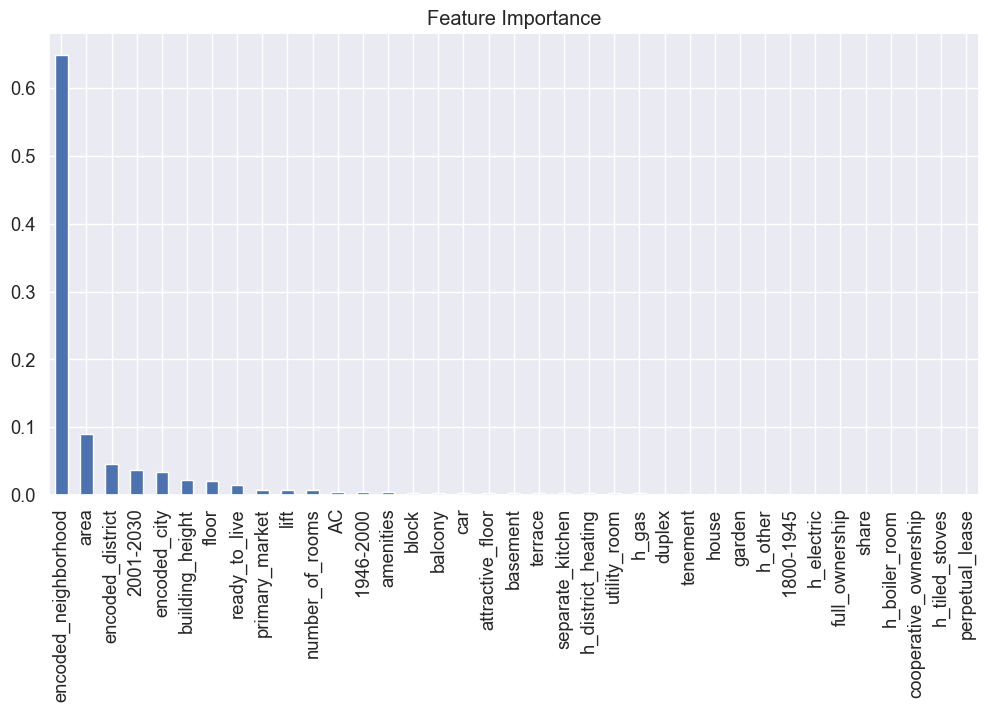

In [80]:
X = df.drop(columns=['neighborhood', 'district', 'city', 'raw_neighborhood', 'raw_district', 'raw_city', 'price_per_sq_meter'])  # X to macierz cech
y = df['price_per_sq_meter']  # y to zmienna docelowa

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

r2 = r2_score(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f'R² Score: {r2}')
print(f"Mean Absolute Error: {mae}")

importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

feature_importance.plot(kind='bar', figsize=(12, 6))
plt.title("Feature Importance")
plt.show()

**Feature Selection**

In [81]:
X = df[['encoded_neighborhood', 'area', 'encoded_district', '2001-2030', 'encoded_city', 'building_height', 'floor', 'ready_to_live', 'primary_market', 'lift', 'number_of_rooms', 'AC', '1946-2000', 'amenities']]  
y = df['price_per_sq_meter'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

r2 = r2_score(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f'R² Score: {r2}')
print(f"Mean Absolute Error: {mae}")

R² Score: 0.7917144188829561
Mean Absolute Error: 1418.019823629974


**Model Improvement**

In [82]:
best_params = {
    'bootstrap': False, 
    'max_depth': None, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 1, 
    'min_samples_split': 2, 
    'n_estimators': 300
}

model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

r2 = r2_score(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f'R² Score: {r2}')
print(f"Mean Absolute Error: {mae}")

R² Score: 0.8007975819851465
Mean Absolute Error: 1382.1340531215537


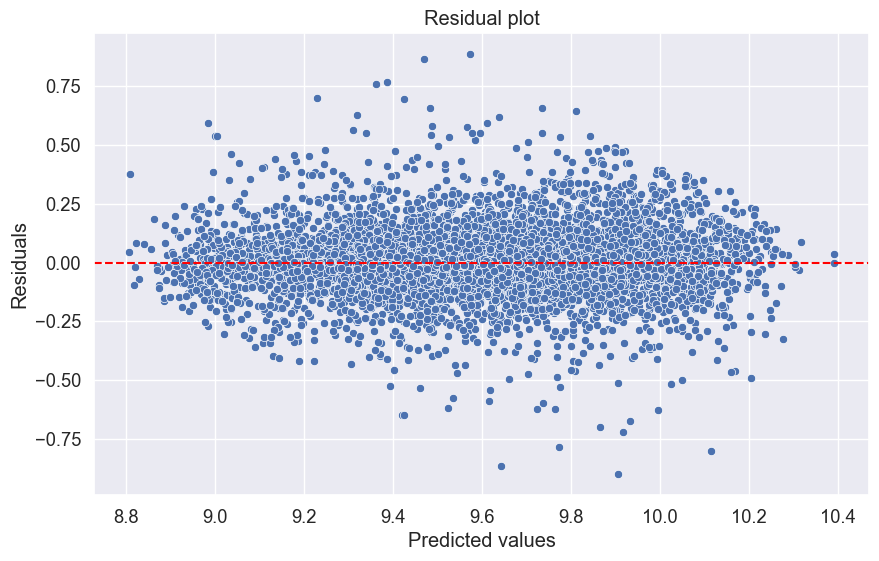

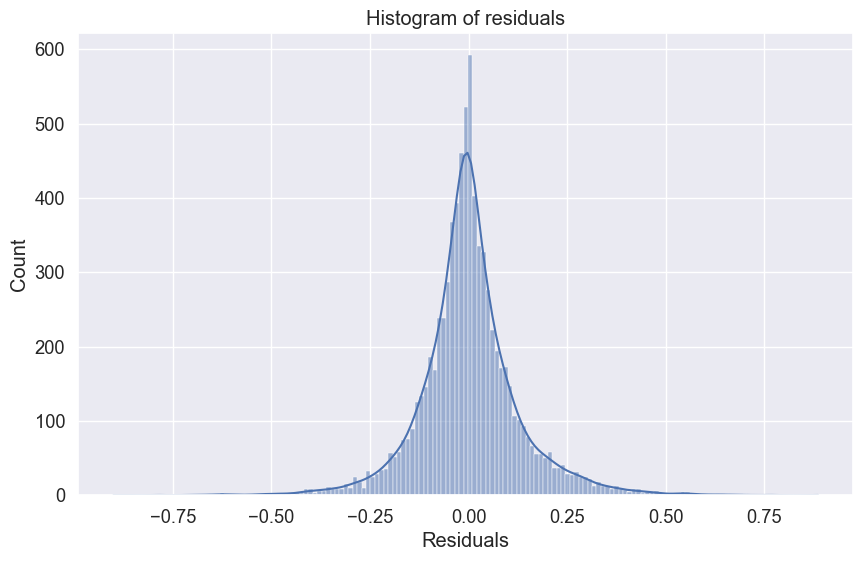

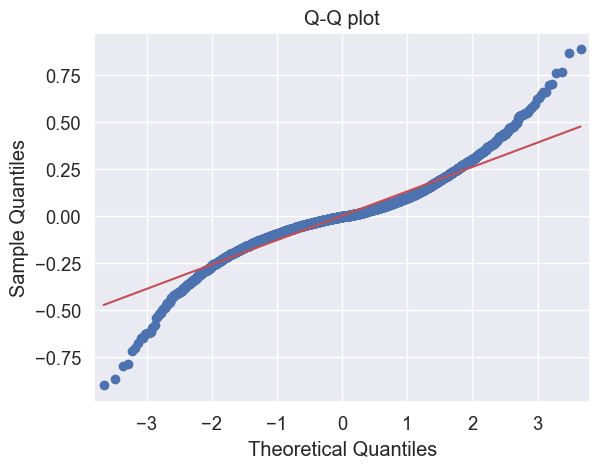

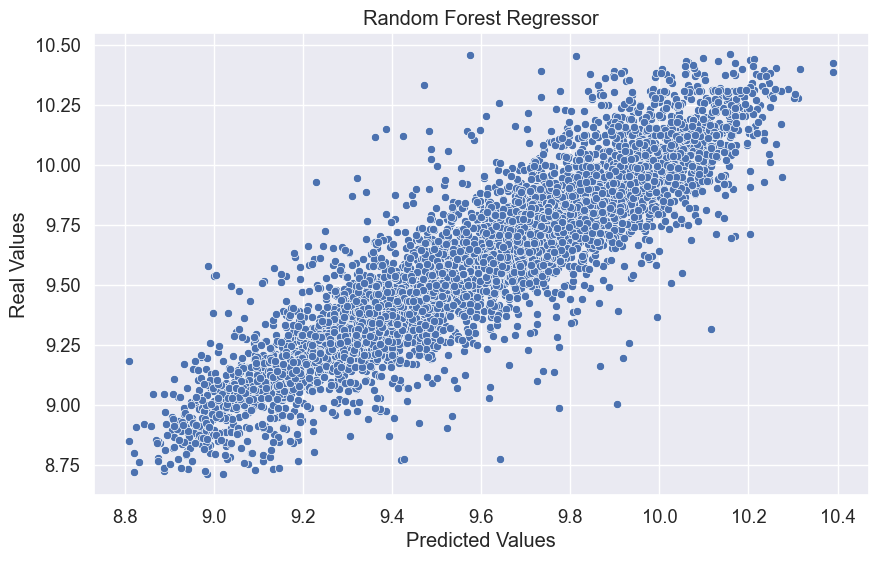

In [83]:
# Residual plot - result should be randomly located around the 0 value
residuals = y_test - y_pred

# Linearity and homoscedasticity: Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# Normality: Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of residuals')
plt.show()

# Normality: Q-Q plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q plot')
plt.show()

# Plotting predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=y_test)
plt.title("Random Forest Regressor")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.show()

Saving the model

In [85]:
# Zapisanie modelu w skompresowanym formacie
with gzip.open('model.pkl.gz', 'wb') as f:
    pickle.dump(model, f)

Creating database with location details

In [86]:
user = "postgres"
password = "password"
host = "localhost"
database = "location_details"
port = "5432"

# Connect to the PostgreSQL server
conn = psycopg2.connect(user=user, password=password, host=host, port=port)
conn.autocommit = True  # Enable autocommit mode
cur = conn.cursor()

cur.execute(sql.SQL("DROP DATABASE IF EXISTS {}").format(sql.Identifier(database)))
cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(database)))
cur.close()
conn.close()

print(f"Baza danych '{database}' została utworzona.")

Baza danych 'location_details' została utworzona.


Database seeding

In [88]:
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")
Base = declarative_base()

class City(Base):
    __tablename__ = 'cities'
    id = Column(Integer, primary_key=True)
    name = Column(String(255), nullable=False, unique=True)
    encoded_city = Column(Float, nullable=True)
    city_avg_price = Column(Float, nullable=True)
    districts = relationship('District', back_populates='city')

class District(Base):
    __tablename__ = 'districts'
    id = Column(Integer, primary_key=True)
    name = Column(String(255), nullable=False)
    city_id = Column(Integer, ForeignKey('cities.id'), nullable=False)
    encoded_district = Column(Float, nullable=True)
    district_avg_price = Column(Float, nullable=True)
    neighborhoods = relationship('Neighborhood', back_populates='district')
    city = relationship('City', back_populates='districts')
    __table_args__ = (UniqueConstraint('name', 'city_id', name='_district_city_uc'),)

class Neighborhood(Base):
    __tablename__ = 'neighborhoods'
    id = Column(Integer, primary_key=True)
    name = Column(String(255), nullable=False)
    district_id = Column(Integer, ForeignKey('districts.id'), nullable=False)
    encoded_neighborhood = Column(Float, nullable=True)
    neighborhood_avg_price = Column(Float, nullable=True)
    district = relationship('District', back_populates='neighborhoods')
    __table_args__ = (UniqueConstraint('name', 'district_id', name='_neighborhood_district_uc'),)

# Create the database tables
Base.metadata.create_all(engine)

# Create a new session
Session = sessionmaker(bind=engine)
session = Session()

try:
    city_mapping = {}
    district_mapping = {}
    neighborhood_mapping = {}

    # Add cities to the database
    cities_to_add = []
    for city_name in df['raw_city'].unique():
        avg_encoded_city = float(df[df['raw_city'] == city_name]['encoded_city'].mean())
        city_avg_price = float(np.exp(df[df['raw_city'] == city_name]['price_per_sq_meter']).mean())
        city = City(name=city_name, encoded_city=avg_encoded_city, city_avg_price=city_avg_price)
        cities_to_add.append(city)
    session.bulk_save_objects(cities_to_add)
    session.commit()

    # Map city names to their IDs
    for city in session.query(City).all():
        city_mapping[city.name] = city.id

    # Add districts to the database
    districts_to_add = []
    for district_name, city_name in df[['raw_district', 'raw_city']].drop_duplicates().itertuples(index=False):
        avg_encoded_district = float(df[(df['raw_district'] == district_name) & (df['raw_city'] == city_name)]['encoded_district'].mean())
        district_avg_price = float(np.exp(df[df['raw_district'] == district_name]['price_per_sq_meter']).mean())
        district = District(name=district_name, city_id=city_mapping[city_name], encoded_district=avg_encoded_district, district_avg_price=district_avg_price)
        districts_to_add.append(district)
    session.bulk_save_objects(districts_to_add)
    session.commit()

    # Map district names and city IDs to their IDs
    for district in session.query(District).all():
        district_mapping[(district.name, district.city_id)] = district.id

    # Add neighborhoods to the database
    neighborhoods_to_add = []
    for neighborhood_name, district_name, city_name in df[['raw_neighborhood', 'raw_district', 'raw_city']].drop_duplicates().itertuples(index=False):
        avg_encoded_neighborhood = float(df[(df['raw_neighborhood'] == neighborhood_name) & (df['raw_district'] == district_name) & (df['raw_city'] == city_name)]['encoded_neighborhood'].mean())
        neighborhood_avg_price = float(np.exp(df[df['raw_neighborhood'] == neighborhood_name]['price_per_sq_meter']).mean())
        neighborhood = Neighborhood(name=neighborhood_name, district_id=district_mapping[(district_name, city_mapping[city_name])], encoded_neighborhood=avg_encoded_neighborhood, neighborhood_avg_price=neighborhood_avg_price)
        neighborhoods_to_add.append(neighborhood)
    session.bulk_save_objects(neighborhoods_to_add)
    session.commit()

except SQLAlchemyError as e:
    session.rollback()
    print(f"An error occurred: {e}")

finally:
    # Close the session
    session.close()

In [90]:
output_file = 'location_db.sql'
command = f'pg_dump --dbname=postgresql://{user}:{password}@{host}:{port}/{database} -F c -b -v -f {output_file}'
subprocess.run(command, shell=True, check=True)
print(f"Baza danych '{database}' została zapisana do pliku '{output_file}'.")

Baza danych 'location_details' została zapisana do pliku 'location_db.sql'.
